In [2]:
import requests
import glob
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from functools import reduce
from ta.momentum import rsi
from ta.trend import ema_indicator
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot

In [18]:
# data collection
all_markets = ["BTC", "ETH", "DOGE", "BNB", "XRP", "TRX", "ZIL", "ADA", "WAVES", "ETC", "LTC", "MATIC", "LINK", "EOS", "ATOM", "XLM"]
col_list = ["open_time", "open", "high", "low", "close", "volume", "close_time", "quote_asset_volume", "number_of_trade", "ignore1", "ignore2", "ignore3"]

for market in all_markets:
    df = pd.DataFrame(columns=col_list)
    startTime = 1622419200000  # 2021-05-31 00:00:00 -> 1 month for cointegration test + 1 day for technical indicator
    endTime = 1648684800000    # 2022-03-31 23:59:59
    while startTime < endTime:
        url = f"https://api.binance.com/api/v3/klines?symbol={market}USDT&interval=1m&startTime={startTime}&limit=1000"
        data = pd.DataFrame(requests.get(url).json(), columns=col_list)
        df = pd.concat([df, data])
        startTime = df.close_time.iloc[-1] + 1
    df.to_csv(market+".csv")

In [40]:
df = pd.DataFrame(columns=col_list)
startTime = 1622419200000  # 2021-05-31 00:00:00 -> 1 month for cointegration test + 1 day for technical indicator
endTime = 1648684800000    # 2022-03-31 23:59:59
while startTime < endTime:
    url = f"https://api.binance.com/api/v3/klines?symbol=BTCUSDT&interval=1m&startTime={startTime}&limit=1000"
    data = pd.DataFrame(requests.get(url).json(), columns=col_list)
    df = pd.concat([df, data])
    startTime = df.close_time.iloc[-1] + 1
df.to_csv("BTC.csv")

In [19]:
# formatting the csv file into ohlcv
token_list = ["BTC", "ETH", "DOGE", "BNB", "XRP", "TRX", "ZIL", "ADA", "WAVES", "ETC", "LTC", "MATIC", "LINK", "EOS", "ATOM", "XLM"]
for i in glob.glob("data/*.csv"):
    df = pd.read_csv(i, index_col=0)
    df["time"] = (df["open_time"]/1000).apply(datetime.utcfromtimestamp)
    df.set_index("time", drop=True, inplace=True)
    df = df[["open", "high", "low", "close", "quote_asset_volume"]]
    df.columns = ["open", "high", "low", "close", "volume"]
    df.to_csv(i)

In [20]:
# aligning the time & backfill the missing data
df_list = []
for i in glob.glob("data/*.csv"):
    token_name = i.split("/")[1].split(".")[0]
    df = pd.read_csv(i, index_col=0)
    col = [token_name + "_" + col_name for col_name in df.columns]
    df.columns = col
    df_list.append(df)

master_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how="outer"), df_list)
master_df.fillna(method="ffill", inplace=True)
master_df = master_df.loc[:"2022-04-01"]

# splitting back into individual csv files
for token in token_list:
    cols = [col for col in master_df.columns if col.startswith(token)]
    df = master_df[cols]
    df.columns = [col.split("_")[1] for col in cols]
    df.to_csv(f"data/{token}.csv")

In [47]:
# populating features & confining time index to predetermined time horizon
for i in glob.glob("data/*.csv"):
    df = pd.read_csv(i, index_col=0, parse_dates=True)
    df["log_rtn"] = np.log(df["close"]).diff()
    for window in [30, 60, 240, 480, 720, 1440]:
        df[f"{window}_ema"] = ema_indicator(df.close, window)
        df[f"{window}_rsi"] = rsi(df.close, window)
        df[f"{window}_vol"] = df["log_rtn"].rolling(window).std()
    df = df.loc["2021-06-01":"2022-03-31"]
    df.to_csv(i)

data/BTC.csv


In [11]:
##################################################################################
###########  END OF DATA ACQUISITION - DO NOT RUN CODE ABOVE THIS CELL ###########
##################################################################################

In [4]:
# reading data
token_list = ["BTC", "ETH", "DOGE", "BNB", "XRP", "TRX", "ZIL", "ADA", "WAVES", "ETC", "LTC", "MATIC", "LINK", "EOS", "ATOM", "XLM"]
pre_data = {}
data = {}
for token in token_list:
    df = pd.read_csv(f"data/{token}.csv", index_col=0, parse_dates=True)
    pre_data[token] = df.loc[:"2021-06-30"]
    data[token] = df.loc["2021-07-01":]

In [5]:
data["ZIL"].shape

(393360, 24)

In [6]:
# clustering using NearestNeighbor using the first data point
# getting the cluster data
cluster_data = pd.DataFrame(columns=token_list)
for token in token_list:
    cluster_data[token] = pre_data[token].iloc[0]
cluster_data = cluster_data.T

# NearestNeighbor
nn = NearestNeighbors(n_neighbors=4)
nn.fit(cluster_data)
neigh = nn.kneighbors()[1]

# Pairs for cointegration test
token0 = [token for token in token_list for i in range(4)]
token1 = [token_list[i] for i in neigh.ravel()]
pairs = pd.DataFrame()
pairs ["pair"] = [list(a) for a in zip(token0, token1)]
pairs ["rev"] = [list(a) for a in zip(token1, token0)]
drop = []
for i in range(len(pairs)):
    if pairs.iloc[i]["rev"] in pairs["pair"].to_list()[i:]:
        drop.append(i)
pairs = pairs.drop(drop, axis=0)["pair"].reset_index(drop=True).to_list()
len(pairs)

38

In [7]:
pairs

[['BTC', 'ADA'],
 ['BTC', 'BNB'],
 ['BTC', 'XRP'],
 ['ETH', 'BTC'],
 ['ETH', 'ADA'],
 ['ETH', 'BNB'],
 ['ETH', 'XRP'],
 ['DOGE', 'ZIL'],
 ['XRP', 'BNB'],
 ['ZIL', 'TRX'],
 ['ADA', 'BNB'],
 ['ADA', 'XRP'],
 ['ADA', 'LINK'],
 ['WAVES', 'TRX'],
 ['WAVES', 'ZIL'],
 ['ETC', 'DOGE'],
 ['ETC', 'ZIL'],
 ['LTC', 'ETC'],
 ['LTC', 'DOGE'],
 ['LTC', 'ZIL'],
 ['MATIC', 'XRP'],
 ['MATIC', 'BNB'],
 ['MATIC', 'ADA'],
 ['LINK', 'MATIC'],
 ['LINK', 'XRP'],
 ['LINK', 'BNB'],
 ['LINK', 'EOS'],
 ['EOS', 'DOGE'],
 ['EOS', 'ETC'],
 ['EOS', 'LTC'],
 ['EOS', 'ZIL'],
 ['ATOM', 'WAVES'],
 ['ATOM', 'TRX'],
 ['ATOM', 'ZIL'],
 ['XLM', 'TRX'],
 ['XLM', 'WAVES'],
 ['XLM', 'ATOM'],
 ['XLM', 'ZIL']]

In [8]:
# cointegration test for all pairs
coint_pairs = []
coint_tstat = []
for pair in pairs:
    price0 = pre_data[pair[0]]["close"]
    price1 = pre_data[pair[1]]["close"]
    res = coint(price0, price1)
    tstat, pval = res[0], res[1]
    if pval < 0.05:
        coint_pairs.append(pair)
        coint_tstat.append(tstat)
        print(f"{pair[0]} - {pair[1]}")
        print(f"It is co integrated with pval - {pval}, tstat - {tstat}")
        print()

DOGE - ZIL
It is co integrated with pval - 0.0050752332870706044, tstat - -4.104010893265754

XRP - BNB
It is co integrated with pval - 0.0002645564067924882, tstat - -4.886678326778122

ADA - BNB
It is co integrated with pval - 0.020962227093316087, tstat - -3.654189493188102

ADA - XRP
It is co integrated with pval - 0.01810691583984039, tstat - -3.7040492141361216

ADA - LINK
It is co integrated with pval - 0.00430959294455947, tstat - -4.151885073323475

LTC - DOGE
It is co integrated with pval - 0.00826938541919443, tstat - -3.9567262774241803

LTC - ZIL
It is co integrated with pval - 0.003517799330564573, tstat - -4.210386626931956

MATIC - BNB
It is co integrated with pval - 0.020827105793967588, tstat - -3.656411422242147

LINK - BNB
It is co integrated with pval - 0.0021207890272933686, tstat - -4.3521068312018585

EOS - DOGE
It is co integrated with pval - 4.228519337957123e-05, tstat - -5.311655110648342

EOS - ZIL
It is co integrated with pval - 2.9909369695855785e-05, tst

In [10]:
# choosing the most cointegrated pairs - EOS-ZIL
coint_df = pd.DataFrame({"pairs": coint_pairs,
                         "tstat": coint_tstat})
coint_df.sort_values(by="tstat", ascending=True).reset_index(drop=True)

,pairs,tstat
0,"[EOS, ZIL]",-5.388334
1,"[EOS, DOGE]",-5.311655
2,"[XRP, BNB]",-4.886678
3,"[ATOM, ZIL]",-4.529478
4,"[XLM, ZIL]",-4.370721
5,"[LINK, BNB]",-4.352107
6,"[LTC, ZIL]",-4.210387
7,"[ADA, LINK]",-4.151885
8,"[DOGE, ZIL]",-4.104011
9,"[LTC, DOGE]",-3.956726


In [11]:
# Finding hedge ratio for each of the cointegrated pairs using OLS regression - using more expensive token as y
# EOS-ZIL
lr1 = LinearRegression()
lr1.fit(pre_data["ZIL"]["close"].values.reshape(-1,1), pre_data["EOS"]["close"])
print(f"1 EOS = {float(lr1.coef_)} ZIL")
print()

1 EOS = 44.36561187799406 ZIL



In [12]:
# code snippet for denoising with wavelet transform demonstration with close price of ZIL
denoised_coeff = []
filt = pywt.Wavelet("haar")
max_level = pywt.dwt_max_level(len(data["ZIL"]), filt.dec_len)
series = pywt.wavedec(data["ZIL"].close, "haar", level=2) # choose the level depending on how "strong" the filtering you want to be, larger value = more smoothing, between 2 to max_level
for i in series:
    denoise = pywt.threshold(i, np.std(i))
    denoised_coeff.append(denoise)
denoised_signal = pywt.waverec(denoised_coeff, "haar")

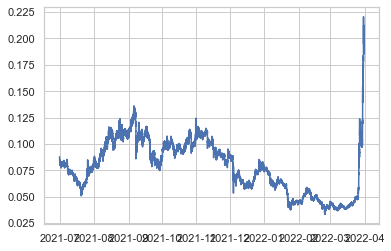

In [13]:
# original signal
import seaborn as sns
sns.set_theme(style= 'whitegrid' )
plt.plot(data["ZIL"].close)

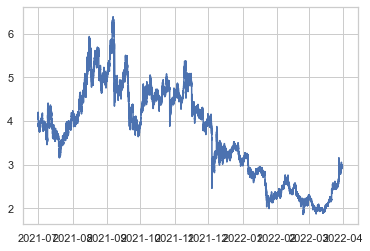

In [16]:
plt.plot(data["EOS"].close)

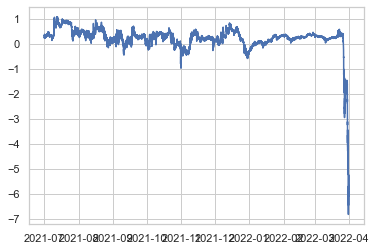

In [18]:
# plot of the spread
plt.plot(data["EOS"].close - 44.366*data["ZIL"].close)

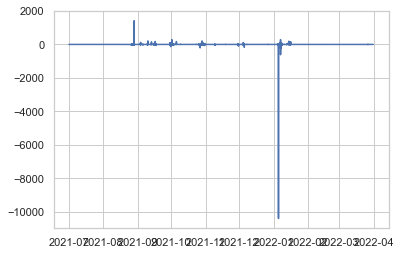

In [32]:
plt.plot( (data["EOS"].close - 44.366*data["ZIL"].close).pct_change() )

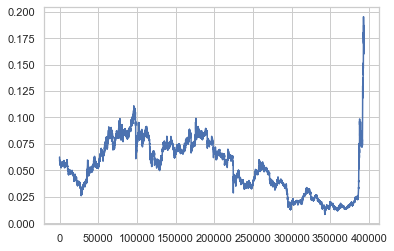

In [19]:
# denoised signal
plt.plot(denoised_signal)

### Preapare for the training and the testing data of the pair data

In [14]:
choosen_pair_token = ["EOS", "ZIL"]

In [15]:
pair_data = pd.DataFrame({'S1_close':data['ZIL']['close'],'S2_close':data['EOS']['close']
                         ,'S1_open':data['ZIL']["open"],'S2_open':data['EOS']["open"]
                         ,'S1_high':data['ZIL']["high"],'S2_high':data['EOS']["high"]
                         ,'S1_low':data['ZIL']["low"],'S2_low':data['EOS']["low"]
                         ,'S1_volume':data['ZIL']["volume"],'S2_volume':data['EOS']["volume"]})

In [25]:
data["ZIL"]

,open,high,low,close,volume,log_rtn,30_ema,30_rsi,30_vol,60_ema,...,240_vol,480_ema,480_rsi,480_vol,720_ema,720_rsi,720_vol,1440_ema,1440_rsi,1440_vol
time,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00,0.08791,0.08804,0.08765,0.08781,2.231479e+04,-0.001138,0.087756,53.869544,0.001529,0.087552,...,0.001697,0.084799,53.344564,0.001737,0.084298,52.229523,0.001943,0.083925,51.352715,0.002167
2021-07-01 00:01:00,0.08781,0.08791,0.08738,0.08738,8.973102e+03,-0.004909,0.087732,47.530207,0.001783,0.087546,...,0.001728,0.084809,52.934411,0.001751,0.084307,51.973006,0.001950,0.083930,51.231364,0.002171
2021-07-01 00:02:00,0.08738,0.08741,0.08718,0.08718,1.446196e+04,-0.002291,0.087696,44.983169,0.001830,0.087534,...,0.001735,0.084819,52.745390,0.001751,0.084315,51.854388,0.001946,0.083934,51.175077,0.002164
2021-07-01 00:03:00,0.08717,0.08725,0.08702,0.08707,7.473268e+03,-0.001263,0.087656,43.652230,0.001834,0.087519,...,0.001737,0.084829,52.641788,0.001752,0.084322,51.789288,0.001945,0.083938,51.144151,0.002163
2021-07-01 00:04:00,0.08704,0.08721,0.08704,0.08720,1.467517e+04,0.001492,0.087627,45.619330,0.001857,0.087508,...,0.001738,0.084838,52.751696,0.001753,0.084330,51.860812,0.001945,0.083943,51.179043,0.002163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 10:25:00,0.19757,0.19762,0.19583,0.19697,1.494760e+06,-0.003042,0.192968,63.713165,0.004077,0.191917,...,0.004181,0.194016,51.431495,0.004735,0.191113,51.892087,0.005512,0.177708,52.364345,0.005270
2022-03-31 10:26:00,0.19696,0.19723,0.19526,0.19527,8.645501e+05,-0.008668,0.193116,58.311609,0.004387,0.192027,...,0.004190,0.194021,51.184001,0.004750,0.191124,51.719191,0.005520,0.177732,52.261878,0.005275
2022-03-31 10:27:00,0.19527,0.19568,0.19434,0.19559,6.994986e+05,0.001637,0.193276,58.988655,0.004382,0.192144,...,0.004182,0.194028,51.228271,0.004708,0.191137,51.749495,0.005518,0.177757,52.279468,0.005272


In [16]:
col_list=data["ZIL"].columns[6:24]
for col in col_list:
    for cols in choosen_pair_token:
        n=choosen_pair_token.index(cols)
        n=n+1
        Strings="S"+str(n)+"_"+col
        pair_data[Strings]=data[cols][col]


In [17]:
pair_data # a df having data of both pair

,S1_close,S2_close,S1_open,S2_open,S1_high,S2_high,S1_low,S2_low,S1_volume,S2_volume,...,S1_720_rsi,S2_720_rsi,S1_720_vol,S2_720_vol,S1_1440_ema,S2_1440_ema,S1_1440_rsi,S2_1440_rsi,S1_1440_vol,S2_1440_vol
time,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00,0.08781,4.1288,0.08791,4.1381,0.08804,4.1399,0.08765,4.1282,2.231479e+04,123655.088920,...,51.483134,52.229523,0.001647,0.001943,4.023948,0.083925,50.910955,51.352715,0.001871,0.002167
2021-07-01 00:01:00,0.08738,4.1148,0.08781,4.1296,0.08791,4.1375,0.08738,4.1148,8.973102e+03,119223.909846,...,51.280036,51.973006,0.001652,0.001950,4.024074,0.083930,50.811564,51.231364,0.001873,0.002171
2021-07-01 00:02:00,0.08718,4.1097,0.08738,4.1146,0.08741,4.1162,0.08718,4.1050,1.446196e+04,153654.617789,...,51.206346,51.854388,0.001646,0.001946,4.024193,0.083934,50.775429,51.175077,0.001866,0.002164
2021-07-01 00:03:00,0.08707,4.1099,0.08717,4.1099,0.08725,4.1119,0.08702,4.1065,7.473268e+03,61794.388661,...,51.209099,51.789288,0.001645,0.001945,4.024312,0.083938,50.776803,51.144151,0.001866,0.002163
2021-07-01 00:04:00,0.08720,4.1131,0.08704,4.1099,0.08721,4.1167,0.08704,4.1099,1.467517e+04,58306.891546,...,51.253172,51.860812,0.001641,0.001945,4.024435,0.083943,50.798787,51.179043,0.001866,0.002163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 10:25:00,0.19697,2.9730,0.19757,2.9720,0.19762,2.9750,0.19583,2.9710,1.494760e+06,23900.030500,...,50.666265,51.892087,0.000911,0.005512,2.950581,0.177708,50.648119,52.364345,0.001401,0.005270
2022-03-31 10:26:00,0.19527,2.9750,0.19696,2.9730,0.19723,2.9750,0.19526,2.9730,8.645501e+05,3070.550100,...,50.724885,51.719191,0.000912,0.005520,2.950615,0.177732,50.673847,52.261878,0.001401,0.005275
2022-03-31 10:27:00,0.19559,2.9760,0.19527,2.9750,0.19568,2.9760,0.19434,2.9750,6.994986e+05,1442.126200,...,50.754183,51.749495,0.000911,0.005518,2.950650,0.177757,50.686710,52.279468,0.001401,0.005272


In [18]:
pair_data.columns

Index(['S1_close', 'S2_close', 'S1_open', 'S2_open', 'S1_high', 'S2_high',
       'S1_low', 'S2_low', 'S1_volume', 'S2_volume', 'S1_30_ema', 'S2_30_ema',
       'S1_30_rsi', 'S2_30_rsi', 'S1_30_vol', 'S2_30_vol', 'S1_60_ema',
       'S2_60_ema', 'S1_60_rsi', 'S2_60_rsi', 'S1_60_vol', 'S2_60_vol',
       'S1_240_ema', 'S2_240_ema', 'S1_240_rsi', 'S2_240_rsi', 'S1_240_vol',
       'S2_240_vol', 'S1_480_ema', 'S2_480_ema', 'S1_480_rsi', 'S2_480_rsi',
       'S1_480_vol', 'S2_480_vol', 'S1_720_ema', 'S2_720_ema', 'S1_720_rsi',
       'S2_720_rsi', 'S1_720_vol', 'S2_720_vol', 'S1_1440_ema', 'S2_1440_ema',
       'S1_1440_rsi', 'S2_1440_rsi', 'S1_1440_vol', 'S2_1440_vol'],
      dtype='object')

In [19]:
col_for_cal_spread=data["ZIL"].columns[0:4]
for col in col_for_cal_spread:
    lr=LinearRegression()
    S_one="S1_"+col
    S_two="S2_"+col
    lr.fit(pair_data[S_one].values.reshape(-1,1),pair_data[S_two].values.reshape(-1,1))
    spread_coef=-lr.coef_[0]
    String_spread="Spread_"+col
    pair_data[String_spread]=pair_data[S_one]+(pair_data[S_two]*spread_coef)


In [20]:
pair_data

,S1_close,S2_close,S1_open,S2_open,S1_high,S2_high,S1_low,S2_low,S1_volume,S2_volume,...,S1_1440_ema,S2_1440_ema,S1_1440_rsi,S2_1440_rsi,S1_1440_vol,S2_1440_vol,Spread_open,Spread_high,Spread_low,Spread_close
time,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00,0.08781,4.1288,0.08791,4.1381,0.08804,4.1399,0.08765,4.1282,2.231479e+04,123655.088920,...,4.023948,0.083925,50.910955,51.352715,0.001871,0.002167,-157.697819,-157.547380,-157.520889,-157.332656
2021-07-01 00:01:00,0.08738,4.1148,0.08781,4.1296,0.08791,4.1375,0.08738,4.1148,8.973102e+03,119223.909846,...,4.024074,0.083930,50.811564,51.231364,0.001873,0.002171,-157.373814,-157.456125,-157.009567,-156.799302
2021-07-01 00:02:00,0.08718,4.1097,0.08738,4.1146,0.08741,4.1162,0.08718,4.1050,1.446196e+04,153654.617789,...,4.024193,0.083934,50.775429,51.175077,0.001866,0.002164,-156.802294,-156.645583,-156.635618,-156.605053
2021-07-01 00:03:00,0.08707,4.1099,0.08717,4.1099,0.08725,4.1119,0.08702,4.1065,7.473268e+03,61794.388661,...,4.024312,0.083938,50.776803,51.144151,0.001866,0.002163,-156.623293,-156.482011,-156.693045,-156.612788
2021-07-01 00:04:00,0.08720,4.1131,0.08704,4.1099,0.08721,4.1167,0.08704,4.1099,1.467517e+04,58306.891546,...,4.024435,0.083943,50.798787,51.179043,0.001866,0.002163,-156.623423,-156.664821,-156.822832,-156.734666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 10:25:00,0.19697,2.9730,0.19757,2.9720,0.19762,2.9750,0.19583,2.9710,1.494760e+06,23900.030500,...,2.950581,0.177708,50.648119,52.364345,0.001401,0.005270,-113.124772,-113.081777,-113.232533,-113.155831
2022-03-31 10:26:00,0.19527,2.9750,0.19696,2.9730,0.19723,2.9750,0.19526,2.9730,8.645501e+05,3070.550100,...,2.950615,0.177732,50.673847,52.261878,0.001401,0.005275,-113.163512,-113.082167,-113.309460,-113.233786
2022-03-31 10:27:00,0.19559,2.9760,0.19527,2.9750,0.19568,2.9760,0.19434,2.9750,6.994986e+05,1442.126200,...,2.950650,0.177757,50.686710,52.279468,0.001401,0.005272,-113.241462,-113.121794,-113.386737,-113.271593


In [21]:
cols_trained=pair_data.columns[8:]
lstm_pair_data=pair_data[cols_trained].copy()

In [22]:
#count how many data point for each day
n=0
for i in range(10000):
    if "2021-07-01" in str(lstm_pair_data.index[i]):
        n=n+1
#n=1440

In [ ]:
#Wavelet Denoising

In [23]:
def wav_den(ts_orig):
    (ca, cd) = pywt.dwt(ts_orig, 'db8')
    cat = pywt.threshold(ca, np.std(ca)/8, mode='soft')
    cdt = pywt.threshold(cd, np.std(cd)/8, mode='soft')
    ts_rec = pywt.idwt(cat, cdt, 'db8')
    return ts_rec[1:]


In [ ]:
#testing_size: 15 days

In [24]:
train_size=int(len(lstm_pair_data.index)*0.9)
test_size=1440*15
validation_size=int(len(lstm_pair_data.index)-(train_size+test_size)) # around 12.3 days


train= lstm_pair_data[0:train_size]
dev=lstm_pair_data[train_size: (train_size+validation_size)]
test=lstm_pair_data[int(len(lstm_pair_data))-test_size:int(len(lstm_pair_data))]


In [25]:
cols=lstm_pair_data.columns
train_den = pd.DataFrame(columns = cols)
for col in cols:
    train_den[col] = wav_den(train[col])

In [26]:
train_den.columns

Index(['S1_volume', 'S2_volume', 'S1_30_ema', 'S2_30_ema', 'S1_30_rsi',
       'S2_30_rsi', 'S1_30_vol', 'S2_30_vol', 'S1_60_ema', 'S2_60_ema',
       'S1_60_rsi', 'S2_60_rsi', 'S1_60_vol', 'S2_60_vol', 'S1_240_ema',
       'S2_240_ema', 'S1_240_rsi', 'S2_240_rsi', 'S1_240_vol', 'S2_240_vol',
       'S1_480_ema', 'S2_480_ema', 'S1_480_rsi', 'S2_480_rsi', 'S1_480_vol',
       'S2_480_vol', 'S1_720_ema', 'S2_720_ema', 'S1_720_rsi', 'S2_720_rsi',
       'S1_720_vol', 'S2_720_vol', 'S1_1440_ema', 'S2_1440_ema', 'S1_1440_rsi',
       'S2_1440_rsi', 'S1_1440_vol', 'S2_1440_vol', 'Spread_open',
       'Spread_high', 'Spread_low', 'Spread_close'],
      dtype='object')

In [140]:
#Comparison of the performance of the model using different optimizers

In [174]:
# generate the dataset with normalization and set the y as the volume

In [27]:
test.columns[0]

'S1_volume'

In [28]:
look_back=1
scaler = MinMaxScaler(feature_range=(0, 1))
# Create function for creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[(i+1):(i+1+look_back), 0])
    print(len(dataY))
    return dataX, np.array(scaler.fit_transform(dataX)), dataY, np.array(scaler.fit_transform(dataY))

# Generate dataset for trainX, trainY, testX, testY
trainX_untr, trainX, trainY_untr, trainY = create_dataset(train_den.values, look_back)
devX_untr, devX, devY_untr, devY = create_dataset(dev.values, look_back)
testX_untr, testX, testY_untr, testY = create_dataset(test.values, look_back)

354022
17735
21599


In [29]:
train_den

,S1_volume,S2_volume,S1_30_ema,S2_30_ema,S1_30_rsi,S2_30_rsi,S1_30_vol,S2_30_vol,S1_60_ema,S2_60_ema,...,S1_1440_ema,S2_1440_ema,S1_1440_rsi,S2_1440_rsi,S1_1440_vol,S2_1440_vol,Spread_open,Spread_high,Spread_low,Spread_close
0,7445.393503,103177.833700,4.001623,0.084889,49.135812,46.673123,0.001259,0.001681,3.991194,0.084704,...,3.901815,0.081110,50.665088,51.085740,0.001809,0.002107,-152.664798,-152.749908,-152.319050,-152.111029
1,9703.638040,136069.292602,4.000634,0.084853,47.156179,44.136633,0.001242,0.001728,3.991040,0.084692,...,3.901933,0.081114,50.629191,51.029689,0.001803,0.002101,-152.110138,-151.959648,-151.945989,-151.917796
2,5960.265505,54431.696961,3.999716,0.084813,47.012541,42.576552,0.001201,0.001739,3.990903,0.084677,...,3.902053,0.081119,50.625401,50.993650,0.001802,0.002100,-151.912965,-151.776180,-151.983799,-151.903422
3,10291.581226,40204.241077,3.999094,0.084783,48.352498,44.534419,0.001205,0.001763,3.990862,0.084666,...,3.902176,0.081123,50.647177,51.028336,0.001802,0.002100,-151.943849,-151.967293,-152.112695,-152.024409
4,8567.391022,72579.232236,3.997496,0.084744,42.974388,42.356290,0.001336,0.001786,3.990326,0.084649,...,3.902278,0.081128,50.544586,50.977107,0.001804,0.002100,-151.974043,-151.796711,-151.624633,-151.466595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354018,1960.160333,125.352339,1.971098,0.037256,50.280914,55.169483,0.000503,0.000888,1.970846,0.037259,...,2.040791,0.039057,47.883384,48.213156,0.000978,0.001336,-75.132287,-75.042055,-75.235196,-75.136444
354019,362.465735,2.161788,1.971157,0.037262,50.579627,53.413618,0.000500,0.000887,1.970885,0.037262,...,2.040697,0.039055,47.888885,48.189215,0.000978,0.001336,-75.148755,-75.035696,-75.242238,-75.147204
354020,-1600.874601,9.904001,1.971176,0.037269,50.238628,54.344974,0.000500,0.000884,1.970904,0.037266,...,2.040602,0.039053,47.881621,48.206436,0.000978,0.001336,-75.143469,-75.024981,-75.214566,-75.132269
354021,173.694289,18.523625,1.971134,0.037274,48.700263,52.815147,0.000503,0.000879,1.970893,0.037268,...,2.040506,0.039050,47.860366,48.183587,0.000978,0.001336,-75.099069,-75.002172,-75.197269,-75.092900


In [30]:
def acc_metric(true_value, predicted_value):
    acc_met = 0.0
    m = len(true_value)
    for i in range(m):
        acc_met += mean_squared_error(true_value[i], predicted_value[i])
    acc_met /= m
    return np.sqrt(acc_met)

In [ ]:
#optimizer:Adam

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
devX = np.reshape(devX, (devX.shape[0], 1, devX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# Running the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(look_back))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainY, epochs=200, batch_size=20, validation_data=(devX, devY), verbose=0, shuffle=True)

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1, 256)            306176    
                                                                 
 lstm_6 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 831,745
Trainable params: 831,745
Non-trainable params: 0
_________________________________________________________________


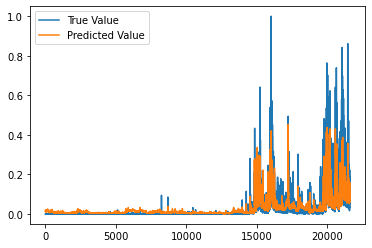

In [60]:
yhat = model.predict(testX)
pyplot.plot(testY, label='True Value')
pyplot.plot(yhat, label='Predicted Value')
pyplot.legend()
pyplot.show()

In [81]:
prediction_data=pd.DataFrame(yhat)

In [83]:
prediction_data.to_csv("data/prediction_data_1.csv")

In [84]:
#root mean square error
acc_metric(testY,yhat)

0.032425342038178595

In [ ]:
#time taken in the model using Adam: 5 hours

In [ ]:
#Using SGD

In [86]:
model_1 = Sequential()
model_1.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model_1.add(LSTM(256))
model_1.add(Dropout(0.2))
model_1.add(Dense(look_back))
model_1.compile(loss='mse', optimizer='SGD', metrics=['accuracy'])
history = model_1.fit(trainX, trainY, epochs=200, batch_size=20, validation_data=(devX, devY), verbose=0, shuffle=True)

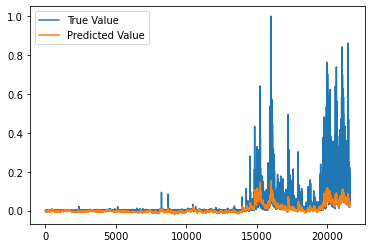

In [87]:
yhat_1 = model_1.predict(testX)
pyplot.plot(testY, label='True Value')
pyplot.plot(yhat_1, label='Predicted Value')
pyplot.legend()
pyplot.show()

In [91]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 256)            306176    
                                                                 
 lstm_10 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 831,745
Trainable params: 831,745
Non-trainable params: 0
_________________________________________________________________


In [88]:
acc_metric(testY,yhat_1)

0.04614133847344337

In [90]:
prediction_data_2=pd.DataFrame(yhat_1)
prediction_data_2.to_csv("data/prediction_data_2.csv")

In [ ]:
#time taken in the model using SGD: 5 hours

In [ ]:
#using RMSprop

In [93]:
model_3 = Sequential()
model_3.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model_3.add(LSTM(256))
model_3.add(Dropout(0.2))
model_3.add(Dense(look_back))
model_3.compile(loss='mse', optimizer='RMSprop', metrics=['accuracy'])
history = model_3.fit(trainX, trainY, epochs=200, batch_size=20, validation_data=(devX, devY), verbose=0, shuffle=True)

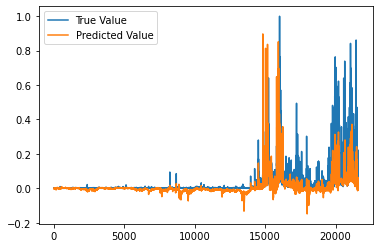

In [94]:
yhat_2 = model_3.predict(testX)
pyplot.plot(testY, label='True Value')
pyplot.plot(yhat_2, label='Predicted Value')
pyplot.legend()
pyplot.show()

In [95]:
acc_metric(testY,yhat_2)

0.045788569356027105

In [96]:
prediction_data_3=pd.DataFrame(yhat_2)
prediction_data_3.to_csv("data/prediction_data_3.csv")

In [ ]:
#time taken in the model using RMSprop: 6 hours

In [ ]:
#real model in predicting the spread_close using Adam in LSTM

In [49]:
test.columns[41]

'Spread_close'

In [106]:
test['Spread_close']

time
2022-03-16 10:30:00    -77.434925
2022-03-16 10:31:00    -77.473052
2022-03-16 10:32:00    -77.434965
2022-03-16 10:33:00    -77.396837
2022-03-16 10:34:00    -77.282515
                          ...    
2022-03-31 10:25:00   -113.155831
2022-03-31 10:26:00   -113.233786
2022-03-31 10:27:00   -113.271593
2022-03-31 10:28:00   -113.348248
2022-03-31 10:29:00   -113.424823
Name: Spread_close, Length: 21600, dtype: float64

In [32]:
look_back=1
scaler = MinMaxScaler(feature_range=(0, 1))
# Create function for creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[(i+1):(i+1+look_back), 41])
    print(len(dataY))
    return dataX, np.array(scaler.fit_transform(dataX)), dataY, np.array(scaler.fit_transform(dataY))

# Generate dataset for trainX, trainY, testX, testY
trainX_untr, trainX, trainY_untr, trainY = create_dataset(train_den.values, look_back)
devX_untr, devX, devY_untr, devY = create_dataset(dev.values, look_back)
testX_untr, testX, testY_untr, testY = create_dataset(test.values, look_back)

354022
17735
21599


In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
devX = np.reshape(devX, (devX.shape[0], 1, devX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# Running the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(look_back))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainY, epochs=200, batch_size=20, validation_data=(devX, devY), verbose=0, shuffle=True)

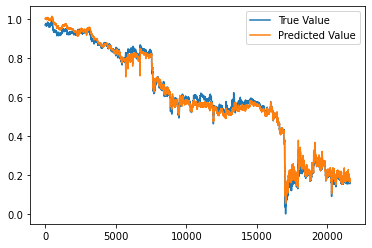

In [126]:
yhat_t = model.predict(testX)
pyplot.plot(testY, label='True Value')
pyplot.plot(yhat_t, label='Predicted Value')
pyplot.legend()
pyplot.show()

In [127]:
acc_metric(testY,yhat_t)

0.02143371782517037

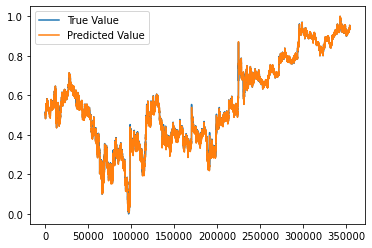

In [137]:
yhat_tx = model.predict(trainX)
pyplot.plot(trainY, label='True Value')
pyplot.plot(yhat_tx, label='Predicted Value')
pyplot.legend()
pyplot.show()

In [138]:
acc_metric(trainY,yhat_tx)

0.002522211726790157

In [128]:
prediction_data_t=pd.DataFrame(yhat_t)
prediction_data_t.to_csv("data/prediction_data_t.csv")

In [131]:
test_Y=pd.DataFrame(testY)
test_Y.to_csv("data/testY.csv")

In [136]:
test_X=pd.DataFrame(testX.reshape(testX.shape[0],testX.shape[2]))
test_X.to_csv("data/testX.csv")

## Backtest
#### Strategy :
-  Let e be a threshold 
-  Buy the Spread when the model predict there will be a e %_change (position  = +1), close positon after n minute
-  Short Sell the Spread when the model predict there will be a -e %_change (position  = -1), close positon after n minute
-  It only take less than 0.002 second to make one row of prediction

In [34]:
# model prediction of the spread close
model_pred = pd.read_csv('prediction_data_t.csv')['0']
y_pred = scaler.inverse_transform(model_pred.values.reshape(-1,1))
y_pred = y_pred.flatten()
y_pred

array([ -76.05324451,  -76.0795679 ,  -76.05778303, ..., -112.84001861,
       -112.93607973, -113.03913857])

In [35]:
y_true = scaler.inverse_transform(testY)
y_true = y_true.flatten()
y_true

array([ -77.47305226,  -77.43496485,  -77.39683744, ..., -113.27159348,
       -113.34824831, -113.42482313])

In [36]:
# test period
print('len of y_true :', len(y_true))
print('len of y_pred :', len(y_pred))
print('len of prediction timeframe :', len(test[1:].index))
test[1:].index

len of y_true : 21599
len of y_pred : 21599
len of prediction timeframe : 21599


DatetimeIndex(['2022-03-16 10:31:00', '2022-03-16 10:32:00',
               '2022-03-16 10:33:00', '2022-03-16 10:34:00',
               '2022-03-16 10:35:00', '2022-03-16 10:36:00',
               '2022-03-16 10:37:00', '2022-03-16 10:38:00',
               '2022-03-16 10:39:00', '2022-03-16 10:40:00',
               ...
               '2022-03-31 10:20:00', '2022-03-31 10:21:00',
               '2022-03-31 10:22:00', '2022-03-31 10:23:00',
               '2022-03-31 10:24:00', '2022-03-31 10:25:00',
               '2022-03-31 10:26:00', '2022-03-31 10:27:00',
               '2022-03-31 10:28:00', '2022-03-31 10:29:00'],
              dtype='datetime64[ns]', name='time', length=21599, freq=None)

In [37]:
backtest_data = pd.DataFrame(index = test[1:].index)
backtest_data['true_spread'] = y_true.tolist()
backtest_data['pred_spread'] = y_pred.tolist()
backtest_data['true_spread_p_change'] = backtest_data['true_spread'].pct_change()*100
backtest_data['pred_spread_p_change'] = (backtest_data['pred_spread'].pct_change()*100)
backtest_data

,true_spread,pred_spread,true_spread_p_change,pred_spread_p_change
time,,,,
2022-03-16 10:31:00,-77.473052,-76.053245,NaN,NaN
2022-03-16 10:32:00,-77.434965,-76.079568,-0.049162,0.034612
2022-03-16 10:33:00,-77.396837,-76.057783,-0.049238,-0.028634
2022-03-16 10:34:00,-77.282515,-76.032620,-0.147709,-0.033084
2022-03-16 10:35:00,-77.282565,-75.957395,0.000065,-0.098937
...,...,...,...,...
2022-03-31 10:25:00,-113.155831,-112.874847,0.034237,-0.013128
2022-03-31 10:26:00,-113.233786,-112.902111,0.068892,0.024154
2022-03-31 10:27:00,-113.271593,-112.840019,0.033389,-0.054996


<AxesSubplot:xlabel='time'>

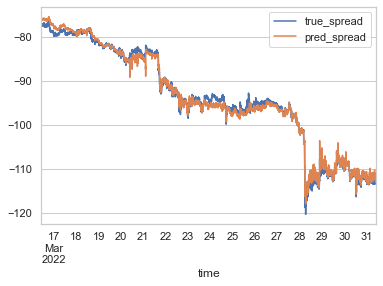

In [39]:
backtest_data.iloc[:,0:2].plot()

In [511]:
backtest_data.iloc[:,0:2]

,true_spread,pred_spread
time,,
2022-03-16 10:31:00,-77.473052,-76.053245
2022-03-16 10:32:00,-77.434965,-76.079568
2022-03-16 10:33:00,-77.396837,-76.057783
2022-03-16 10:34:00,-77.282515,-76.032620
2022-03-16 10:35:00,-77.282565,-75.957395
...,...,...
2022-03-31 10:25:00,-113.155831,-112.874847
2022-03-31 10:26:00,-113.233786,-112.902111
2022-03-31 10:27:00,-113.271593,-112.840019


In [519]:
# Let e be a threshold ( e is a constant )
# Buy the Spread when the model predict there will be a e %_change (position+1), close positon after n minute
# Short Sell the Spread when the model predict there will be a -e %_change (position-1), close positon after n minute

def backtest( start_time = 0, end_time = 22000, n = 30, thresh = 5, initial_cap = 10000, tran_cost = 0.1 * 0.01, w = 10, max_position = 5):
    ''''
    start_time[int]    : backtest start at row = start_time
    end_time[int]      : backtest end at row = end_time
    n[int]             : close position after n minutes (default n = 30)
    w[int]             : make a prediction after w minutes ; n must be divisible by w (default w = 10)
    thresh[float]      : e = (thresh)*(sd of the return predion), open a positon when the model predict there will be a e %_change
    initial_cap[float] : the initial capital of this trading simulation (default initial_cap = 10000)
    max_position[int]  : max. no. of position
    tran_cost[float]   : transaction cost of each trade, default tran_cost = 0.1% ( according to Binance )
    '''

    if end_time > 21599:
        end_time = 21599

    backtest_simulation = backtest_data.iloc[start_time : end_time,0:2].copy() 
    backtest_simulation['pred_spread_p_change_n'] = ( backtest_simulation["pred_spread"].diff(n) / backtest_simulation["pred_spread"].abs().shift(n) ).shift(-n)

    trade_pnl = pd.DataFrame()
    trade_id = 0
    pred_id = 0

    sd = backtest_simulation['pred_spread_p_change_n'].std()
    e = thresh * sd

    position = []
    capital = []
    cash = []
    next_pred_time = []
    for i in range( len(backtest_simulation['pred_spread_p_change_n'].dropna()) +1  ):   # plus one row for initialize position

        if i == 0:                                      # initialize position
            position = position + [0]
            cash = cash + [initial_cap] 
            capital = capital + [cash[pred_id]]
            next_pred_time = next_pred_time + [backtest_simulation.index[pred_id]]
        
        if i >= 1:
            time_now = backtest_simulation.index[i-1] 
            
            if time_now == next_pred_time[-1] :
                next_pred_time = next_pred_time + [ time_now + timedelta(minutes = w) ]
                pred_id = pred_id + 1

                # Opening Position
                if (backtest_simulation.loc[time_now]['pred_spread_p_change_n'] >= e and position[pred_id-1] <= max_position ):    # Buy the spread 

                    if position[pred_id-1] < 0:   # having negative position
                        trade_pnl['Close_time'].replace([None], time_now , inplace=True)  # predict up but having negative position : flat all position
                        # position[pred_id-1] = 0 ('position list' will be modified in close position loop)

                    new_position = position[pred_id-1] + 1
                    position = position + [new_position]

                    trade_id = trade_id + 1
                    new_trade = pd.DataFrame( index = [trade_id])
                    action = 'Buy'
                    open_price = backtest_simulation.loc[time_now]['true_spread']
                    time_close = time_now + timedelta(minutes = n) 

                    new_trade['Action'] = action 
                    new_trade['Open_time'] = time_now
                    new_trade['Open_price'] = open_price
                    new_trade['Close_time'] = time_close
                    new_trade['Close_price'] = [None]
                    new_trade['return'] = [None]
                    trade_pnl = pd.concat( [trade_pnl, new_trade])

                    new_cash = cash[pred_id-1] - open_price - abs(open_price)*tran_cost
                    cash = cash + [new_cash] 
                    
                elif (backtest_simulation.iloc[i-1]['pred_spread_p_change_n'] <= -e and position[pred_id-1] >= -max_position ):     # Sell / Short Sell the Spread 

                    if position[pred_id-1] > 0:   # having positive position
                        trade_pnl['Close_time'].replace([None], time_now , inplace=True)  # predict down but having positive position : flat all position
                        # position[pred_id-1] = 0 ('position list' will be modified in close position loop)

                    new_position = position[pred_id-1] -1
                    position = position + [new_position]

                    trade_id = trade_id + 1
                    new_trade = pd.DataFrame( index = [trade_id])
                    action = 'Sell'
                    open_price = backtest_simulation.loc[time_now]['true_spread']
                    time_close = time_now + timedelta(minutes = n) 

                    new_trade['Action'] = action 
                    new_trade['Open_time'] = time_now
                    new_trade['Open_price'] = open_price - abs(open_price)*tran_cost
                    new_trade['Close_time'] = time_close
                    new_trade['Close_price'] = None
                    new_trade['return'] = None
                    trade_pnl = pd.concat( [trade_pnl, new_trade])

                    new_cash = cash[pred_id-1] + open_price
                    cash = cash + [new_cash] 

                else :
                    new_position = position[pred_id-1]
                    new_cash = cash[pred_id-1] 
                    cash = cash + [new_cash] 
                    position = position + [new_position]

                # close postion  
                if  len(trade_pnl) >0 :
                    for id in np.where( trade_pnl['Close_time']  == time_now)[0] :
                        id = id +1   # trade_id start from 1 but not 0
                        
                        open_price = trade_pnl.loc[id]['Open_price']
                        close_price = backtest_simulation.loc[time_now]['true_spread']

                        if trade_pnl.loc[id]['Action'] == 'Buy':

                            trade_return = (close_price - open_price - abs(open_price)*tran_cost )/ abs(open_price )
                            # leveraged_return = trade_return * leverage_ratio 

                            position[pred_id] = position[pred_id] -1          # close position
                            cash[pred_id] = cash[pred_id] + close_price

                        if trade_pnl.loc[id]['Action'] == 'Sell':
                            trade_return = (open_price - close_price - abs(open_price)*tran_cost)/ abs(open_price )
                            position[pred_id] = position[pred_id] +1          # close position
                            cash[pred_id] = cash[pred_id] - close_price

                        # leveraged_return = trade_return * leverage_ratio + 1
                        trade_pnl.loc[id,['Close_price'] ] = close_price
                        trade_pnl.loc[id,['return'] ] = trade_return + 1

                new_capital = cash[pred_id] + position[pred_id] * backtest_simulation.loc[time_now]['true_spread']
                capital = capital + [new_capital]
            
    nav = pd.DataFrame(index = next_pred_time)
    nav['Position'] = position
    nav['Cash'] = cash
    nav['Capital'] = capital

    win_rate = len( trade_pnl[ trade_pnl['return'] > 1]) / len(trade_pnl.dropna())
    mean_return = trade_pnl['return'].mean()
    mmd = (nav['Capital'].max() - nav['Capital'].min()) / initial_cap
    annualized_return = (nav['Capital'][-1]/ initial_cap)**(365*42*60/21599)

    print('win rate :', win_rate)
    print('expected return per tarde (transaction cost) :', mean_return )
    print('Max. Drawdown :',  mmd)
    print('Annualized Return :',  annualized_return)

    return ( nav, trade_pnl )

In [554]:
backtest_simulation, trade_pnl = backtest( start_time = 0, end_time = 22000, n = 30, thresh = 2, initial_cap = 1200, tran_cost = 0.1 * 0.01,  w = 10, max_position = 5)

win rate : 0.90625
expected return per tarde (transaction cost) : 1.0168897939002055
Max. Drawdown : 0.15311618550724082
Annualized Return : 378.17318699897714


In [571]:
trade_pnl.to_csv('STAT4012_trade_pnl.csv')
trade_pnl

,Action,Open_time,Open_price,Close_time,Close_price,return
1,Buy,2022-03-18 11:11:00,-78.387740,2022-03-18 11:41:00,-78.425718,0.998516
2,Sell,2022-03-20 09:01:00,-85.064713,2022-03-20 09:31:00,-83.951233,0.98591
3,Buy,2022-03-20 09:31:00,-83.951233,2022-03-20 10:01:00,-83.98921,0.998548
4,Buy,2022-03-20 12:11:00,-82.960630,2022-03-20 12:41:00,-83.493944,0.992571
5,Sell,2022-03-20 17:11:00,-83.616074,2022-03-20 17:41:00,-82.465573,0.985241
...,...,...,...,...,...,...
92,Buy,2022-03-30 13:01:00,-115.561041,2022-03-30 13:31:00,-112.584063,1.024761
93,Buy,2022-03-30 13:11:00,-114.949702,2022-03-30 13:41:00,-111.862142,1.02586
94,Buy,2022-03-30 14:41:00,-113.353431,2022-03-30 15:11:00,-111.256853,1.017496
95,Sell,2022-03-30 15:31:00,-111.405134,2022-03-30 16:01:00,-113.047302,1.01374


In [570]:
df = pd.concat( [backtest_data.iloc[:,0:2], backtest_simulation], axis  = 1).fillna(method="ffill")
df.index.name = 'Time'
df[['Position', 'Cash', 'Capital']]
df[['Position', 'Cash', 'Capital']].to_csv('STAT4012_backtest_simulation.csv')

In [564]:
performance_df = pd.concat( [df['Capital'] / 1200 , data['BTC'].close[-21599:]/ 40388.30], axis = 1 )
performance_df.columns = ['Pair Trade strategy with LSTM', 'Market(Buy and hold BTC)']
performance_df

,Pair Trade strategy with LSTM,Market(Buy and hold BTC)
2022-03-16 10:31:00,1.000000,1.000000
2022-03-16 10:32:00,1.000000,0.999817
2022-03-16 10:33:00,1.000000,0.999604
2022-03-16 10:34:00,1.000000,0.998482
2022-03-16 10:35:00,1.000000,0.998780
...,...,...
2022-03-31 10:25:00,1.149556,1.170197
2022-03-31 10:26:00,1.149556,1.170905
2022-03-31 10:27:00,1.149556,1.171368
2022-03-31 10:28:00,1.149556,1.170637


<AxesSubplot:>

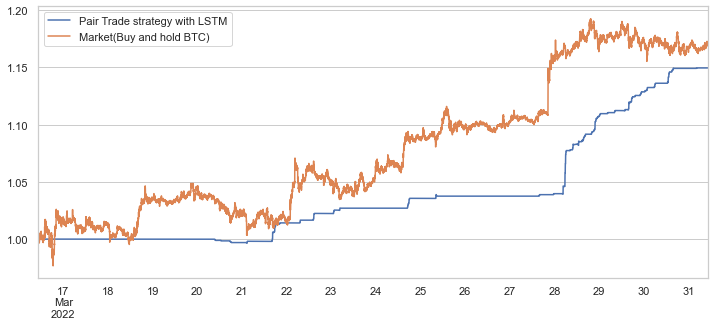

In [565]:
performance_df.plot( figsize=(12, 5) )

In [591]:
our_strat = performance_df.iloc[:,0]
previous_high = 0
drawdown = []
for i in range(len(our_strat)):
    if our_strat[i] > previous_high:
        previous_high = our_strat[i]

    drawdown = drawdown  + [our_strat[i] / previous_high -1 ]
mdd_our_strat = pd.DataFrame(drawdown ).min()
mdd_our_strat

0   -0.00356
dtype: float64

In [592]:
btc = performance_df.iloc[:,1]
previous_high = 0
drawdown = []
for i in range(len(btc)):
    if btc[i] > previous_high:
        previous_high = btc[i]

    drawdown = drawdown  + [our_strat[i] / previous_high -1 ]
mdd_btc = pd.DataFrame(drawdown).min()
mdd_btc

0   -0.114711
dtype: float64

In [527]:
backtest_data.iloc[:,0:2].to_csv('STAT4012_backtest_data.csv')
backtest_data.iloc[:,0:2]

,true_spread,pred_spread
time,,
2022-03-16 10:31:00,-77.473052,-76.053245
2022-03-16 10:32:00,-77.434965,-76.079568
2022-03-16 10:33:00,-77.396837,-76.057783
2022-03-16 10:34:00,-77.282515,-76.032620
2022-03-16 10:35:00,-77.282565,-75.957395
...,...,...
2022-03-31 10:25:00,-113.155831,-112.874847
2022-03-31 10:26:00,-113.233786,-112.902111
2022-03-31 10:27:00,-113.271593,-112.840019


In [563]:
# Portfolio market(BTC) corr
pd.concat( [ data['BTC'][-21599:].close, df.Capital] , axis = 1).pct_change().corr()

,close,Capital
close,1.00000,-0.01116
Capital,-0.01116,1.00000


In [529]:
market_win_rate = len( data['BTC'][-21599:].close.pct_change()[ data['BTC'][-21599:].close.pct_change() > 0]) / len(data['BTC'][-21599:].close.pct_change().dropna())
market_annualized_return = (data['BTC'][-21599:].close[-1]/ data['BTC'][-21599:].close[0])**(365*42*60/21599)

print('market win rate :', market_win_rate)
print('Annualized Return :', market_annualized_return)

market win rate : 0.5031021390869524
Annualized Return : 823.2418081734024


In [530]:
df
daily_return = []
market_daily_return = []
original_capital = df['Capital'][0]
market_original_capital = data['BTC'][-21599:].close[0]

for i in range( (24*60 - 1) , len(df), 24*60):
    day_return = df['Capital'][i] / original_capital
    market_day_return = data['BTC'][-21599:].close[i] / market_original_capital

    daily_return = daily_return +[day_return]
    market_daily_return = market_daily_return +[market_day_return]
    original_capital = df['Capital'][i]
    market_original_capital = data['BTC'][-21599:].close[i]
# the last day
daily_return = daily_return + [ df['Capital'][-1] / df['Capital'][i]]
market_daily_return = market_daily_return + [ data['BTC'][-21599:].close[-1] / data['BTC'][-21599:].close[i]]

In [502]:
market_daily_return 

[1.0072721555499984,
 0.9983604546579679,
 1.025854782346854,
 1.0015629271378823,
 0.990353105987391,
 1.0329392014510272,
 0.988433861717476,
 1.0190065201234635,
 1.026296406466328,
 1.0067877245814976,
 1.0027906001028186,
 1.0601168978961522,
 1.0067965261917158,
 0.9935017153158261,
 1.0008994113501943]

In [575]:
daily_return = pd.DataFrame(daily_return)
market_daily_return = pd.DataFrame(market_daily_return)
pd.concat( [daily_return , market_daily_return], axis =1)

,0,0
0,1.000000,1.007272
1,1.000000,0.998360
2,0.999988,1.025855
3,0.999885,1.001563
4,0.999886,0.990353
5,1.002226,1.032939
6,1.001253,0.988434
7,1.000000,1.019007
8,1.001258,1.026296
9,1.000000,1.006788


In [568]:
pd.concat( [daily_return , market_daily_return], axis =1).std()

0    0.001666
0    0.019125
dtype: float64

In [507]:
# sharpe 
print( 'Portfoliio Sharpe :', daily_return.mean() / daily_return.std() * (365)**(1/2) )
print( 'Market(BTC) Sharpe :', market_daily_return.mean() / market_daily_return.std() * (365)**(1/2) )

Portfoliio Sharpe : 0    1920.406646
dtype: float64
Market(BTC) Sharpe : 0    1009.672738
dtype: float64
